In [3]:
import os
os.chdir('/Users/bnowacki/Documents/Git Repositories/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *


cc_data = load_processed_data(data_type='cc')
pulse_data = load_processed_data(data_type='slowpulse')

/opt/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


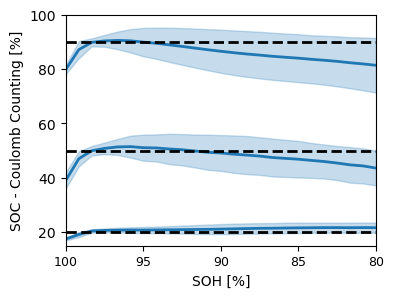

In [4]:

colors = {
	'default':['C0', 'C1', 'C2'],
	'by_group':{
		1:{'main':'#4E79A7', 'fill':'#A0CBE8'},
		2:{'main':'#F28E2B', 'fill':'#FFBE7D'},
		3:{'main':'#59A14F', 'fill':'#8CD17D'},
		4:{'main':'#D37295', 'fill':'#FABFD2'},
		5:{'main':'#499894', 'fill':'#86BCB6'},
		6:{'main':'#E15759', 'fill':'#FF9D9A'},
		7:{'main':'#363433', 'fill':'#94908e'},
		8:{'main':'#B6992D', 'fill':'#F1CE63'},
		9:{'main':'#B07AA1', 'fill':'#D4A6C8'},
		10:{'main':'#9D7660', 'fill':'#D7B5A6'},
		11:{'main':'#637939', 'fill':'#8CA252'},
	},
}

def plot_soc_drift(socs_to_plot=[20,50,90], color_by_group=True, filename:Path=None):
	#region: get plotting data
	plotting_res = pd.DataFrame(columns=['cell_id', 'group_id', 'soc', 'soc_coulomb', 'soh'])
	soh_interp = np.linspace(80,100,25)
	temp = {'cell_id':[],'group_id':[],'soc_coulomb':[],'soc':[],'soh':[]}
	for i, soc in enumerate([20,50,90]):
		for cell_id in sorted(np.unique(pulse_data['cell_id']), reverse=False):
			filts_idxs = np.where( (pulse_data['cell_id'] == cell_id) &  \
								(pulse_data['soc'] == soc) & \
								(pulse_data['pulse_type'] == 'chg'))
			q0 = pulse_data['q_dchg'][filts_idxs][np.where(pulse_data['rpt'][filts_idxs] == 0)]
			sohs = pulse_data['q_dchg'][filts_idxs] / q0 * 100
			socs_coulomb = pulse_data['soc - coulomb'][filts_idxs]

			
			sort_idxs = np.argsort(sohs)
			f_soc = interpolate.PchipInterpolator(sohs[sort_idxs], socs_coulomb[sort_idxs])
			socs_coulomb_interp = f_soc(soh_interp)

			temp['cell_id'] = np.full(len(soh_interp), cell_id)
			temp['group_id'] = np.full(len(soh_interp), get_group_id(cell_id))
			temp['soc'] = np.full(len(soh_interp), soc)
			temp['soc_coulomb'] = socs_coulomb_interp
			temp['soh'] = soh_interp

			if plotting_res.empty:
				plotting_res = pd.DataFrame(temp)
			else:
				plotting_res = pd.concat([plotting_res, pd.DataFrame(temp)], ignore_index=True)
	#endregion

	fig, ax = plt.subplots(figsize=(4,3))
	plotting_res = plotting_res.loc[plotting_res['cell_id'] != 42]

	if color_by_group:
		for group_id,df_split in plotting_res.sort_values(by=['group_id', 'cell_id', 'soc', 'soh'], ascending=[True, True, True, True]).groupby('group_id'):
			# for each group, group by cell_id
			means = df_split.groupby(['soc', 'soh'])['soc_coulomb'].mean().reset_index()
			stds = df_split.groupby(['soc', 'soh'])['soc_coulomb'].std().reset_index()

			for i, soc in enumerate(socs_to_plot):
				if i == 0:
					ax.plot(
						means.loc[means['soc'] == soc, 'soh'], 
						means.loc[means['soc'] == soc, 'soc_coulomb'],
						'-', linewidth=2, color=colors['by_group'][group_id]['main'], label=group_id, zorder=2)
				else:
					ax.plot(
						means.loc[means['soc'] == soc, 'soh'], 
						means.loc[means['soc'] == soc, 'soc_coulomb'],
						'-', linewidth=2, color=colors['by_group'][group_id]['main'], zorder=2)
				ax.fill_between(
					means.loc[means['soc'] == soc, 'soh'], 
					means.loc[means['soc'] == soc, 'soc_coulomb'] + 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					means.loc[means['soc'] == soc, 'soc_coulomb'] - 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					color=colors['by_group'][group_id]['fill'], alpha=0.25, zorder=1)
	else:
		means = plotting_res.groupby(['soc', 'soh'])['soc_coulomb'].mean().reset_index()
		stds = plotting_res.groupby(['soc', 'soh'])['soc_coulomb'].std().reset_index()

		for i, soc in enumerate(socs_to_plot):
			ax.plot(
				means.loc[means['soc'] == soc, 'soh'], 
				means.loc[means['soc'] == soc, 'soc_coulomb'],
				'-', linewidth=2, color=colors['default'][0], zorder=2)
			ax.fill_between(
					means.loc[means['soc'] == soc, 'soh'], 
					means.loc[means['soc'] == soc, 'soc_coulomb'] + 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					means.loc[means['soc'] == soc, 'soc_coulomb'] - 2*stds.loc[stds['soc'] == soc, 'soc_coulomb'].values,
					color=colors['default'][0], alpha=0.25, zorder=1)

	soh_range = np.arange(100,79,-5)
	soc_bounds_mapping = {20:[15,25], 50:[30,60], 90:[60,100]}
	soc_bounds = (soc_bounds_mapping[min(socs_to_plot)][0], soc_bounds_mapping[max(socs_to_plot)][1])

	for soc in socs_to_plot:
		ax.plot(soh_range, np.full(len(soh_range), soc), 'k--', linewidth=2)

	ax.set_xlim([np.max(soh_range), np.min(soh_range)])
	ax.set_xticks(soh_range, labels=soh_range, fontsize=9)
	ax.set_ylim(soc_bounds)
	# ax.set_yticks(np.arange(20,101,20), labels=np.arange(20,101,20), fontsize=9)
	ax.set_xlabel("SOH [%]", fontsize=10)
	ax.set_ylabel("SOC - Coulomb Counting [%]", fontsize=10)
	if color_by_group:
		ax.legend(
			title='Group ID', ncol=1, title_fontsize=10, fontsize=8,
			loc='center right', bbox_to_anchor=(1.3, 0.5), 
			handlelength=1, borderpad=0.75,
			fancybox=True, shadow=True)
		box = ax.get_position()
		ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
	# fig.tight_layout(pad=0.5)
	if filename is not None:
		fig.savefig(filename, dpi=300, bbox_inches="tight")
	plt.show()

socs_to_plot = [20,50,90]
color_by_group = False
dir_save = dir_figures.joinpath("raw", "SOC Drift Analysis")
dir_save.mkdir(exist_ok=True, parents=True)
plot_soc_drift(
	socs_to_plot, 
	color_by_group, 
	filename=None #dir_save.joinpath(f"SOC_Drift_{socs_to_plot}{'_byGroup' if color_by_group else ''}.pdf")
)